# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
# the datasets can be downloaded from https://github.com/udacity/dog-project

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


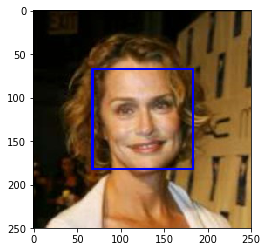

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# percentage for the detection of human faces in human_files_short
count_detected = 0
for i in range(len(human_files_short)):
     count_detected += face_detector(human_files_short[i])
percent_detected_human = float(count_detected)/float(len(human_files_short))*100

# perecentage for the detection of human faces in dog_files_SHORT
count_detected = 0
for i in range(len(dog_files_short)):
     count_detected += face_detector(dog_files_short[i])
percent_detected_dog = float(count_detected)/float(len(dog_files_short))*100

print("percentage for human faces detected in the first 100 images in human_files:", percent_detected_human, "%")
print("percentage for human faces detected in the first 100 images in dog_files:", percent_detected_dog, "%")

percentage for human faces detected in the first 100 images in human_files: 98.0 %
percentage for human faces detected in the first 100 images in dog_files: 11.0 %


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.


Th above result means that, the OpenCV detects human faces in the images with human faces with high accuracy. 
On the other hand, it mistakenly detects human faces in the images with dogs (i.e. high false positive rate). 
I expect that there are better methods for detecting human faces such as those based on deep learning. 

Since given images can contain vague images of human faces, it is nice to introduce a human face detector based on deep learning which automatically extracts features of human faces through training with a large data set. This enables us to detect human faces even when they look vague for human eyes. Various
deep learning based models have been proposed for this purpose. For example, [faster R-CNN](https://arxiv.org/pdf/1606.03473.pdf), 
[CNN Cascade](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.719.805&rep=rep1&type=pdf) 
and [YOLO-based face detection](https://github.com/dannyblueliu/YOLO-version-2-Face-detection). 
(We will work on them in near future.)


In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# perecentage for the detection of dogs in human_files_short
count_detected = 0
for i in range(len(human_files_short)):
     count_detected += dog_detector(human_files_short[i])
percent_detected_human = float(count_detected)/float(len(human_files_short))*100

# perecentage for the detection of dogs in dog_files_short
count_detected = 0
for i in range(len(dog_files_short)):
     count_detected += dog_detector(dog_files_short[i])
percent_detected_dog = float(count_detected)/float(len(dog_files_short))*100

print("percentage for dogs detected in the first 100 images in human_files:", percent_detected_human, "%")
print("percentage for dogs detected in the first 100 images in dog_files:", percent_detected_dog, "%")

percentage for dogs detected in the first 100 images in human_files: 1.0 %
percentage for dogs detected in the first 100 images in dog_files: 100.0 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:17<00:00, 48.07it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters = 16, kernel_size = 2, padding = "same", activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Flatten())
# model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        8256      
__________

Our CNN architecture is very close to the one in the hint. The only differences are (1) some dropout layers are 
added and (2) the global average pooling layer is removed (and Flatten() is added to change the shape of the 3-dimensional input data to a vector). The basic structure of this network is:

- Three convolution layers (with 2x2 filters, strides = 1, "same" padding, and Relu activation function) followed by the max pooling layer with pool size = 2. 
- The "same" padding is used for the convolution layers and thus the shape of the output is the same as that of the input there. Each max pooling layer following each convolution layer squeezes out the spatial information into half. 
- On the other hand, more number of the filters are used in later convolution layers (thus the third dimension of the output becomes larger for later convolution layers).
- Just after the final max pooling layer, Flatten() is used to convert the 3-dimensional data to a vector which then is mapped in the end to the output layer with the softmax activation for the classification with 133 breeds of dogs. 
- Some dropout layers are introduced to avoid the overfitting. Since the size of the training set is not that large and thus too much overfitting is not expected (considering the number of the paramters in the network), the parameters for the dropout layer are set to small (0.2). 
- We also analyzed the case with the global average pooling layer as in the hint, but we got a higher accuracy for our model.  

This CNN architecture close the one in the hint works well for the classification because:<br>
the multiple convolutional layers allow to capture the features in multiple levels of complexity (i.e. early convolutional layer captures simple features while later convolution one does more complicated features). To classify the dog breeds, both simple and complicated features will be needed to be captured (some breeds are very similar even for human eyes). Thus capturing features in multiple levels of complexity is useful for this classification task. 


### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 5

### train the model with augmentation
# augmentation (here we will carry out the augumentation for the training set)
# (one can do the augmentation of the validation set in a similar way)
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rotation_range = 30, 
                width_shift_range = 0.1,
                height_shift_range = 0.1,
                rescale = 1.,
                shear_range = 0.1,
                zoom_range = 0.1,
                horizontal_flip = True,
                fill_mode = 'nearest')

train_datagen.fit(train_tensors)

# train the model!
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size = 10), 
                       validation_data=(valid_tensors, valid_targets), steps_per_epoch = 2000,
                       epochs=epochs, callbacks=[checkpointer], verbose=1)


# ### for check of the augmentation
# count = 0
# for tensor_batch, target_batch in train_datagen.flow(train_tensors, train_targets, batch_size = 10):
#     count += 1 
#     print(count,"th batch")
#     for i in range(0, 9):
#         plt.subplot(331+i)
#         plt.imshow(tensor_batch[i].reshape(224, 224, 3))
#     # show the plot
#     plt.show()
#     if count > 10:
#         break


#### if one does not want to apply the augmentation, use the following original part instead
# ### Do NOT modify the code below this line.

# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
#                                verbose=1, save_best_only=True)

# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5
2000/2000 [==============================] - 679s - loss: 4.7359 - acc: 0.0306 - val_loss: 4.6179 - val_acc: 0.0455
Epoch 2/5
2000/2000 [==============================] - 1334s - loss: 4.4312 - acc: 0.0608 - val_loss: 4.4832 - val_acc: 0.0575
Epoch 3/5
2000/2000 [==============================] - 681s - loss: 4.3493 - acc: 0.0701 - val_loss: 4.5419 - val_acc: 0.0491
Epoch 4/5
2000/2000 [==============================] - 721s - loss: 4.3304 - acc: 0.0729 - val_loss: 4.6506 - val_acc: 0.0371
Epoch 5/5
2000/2000 [==============================] - 674s - loss: 4.3388 - acc: 0.0708 - val_loss: 4.8774 - val_acc: 0.0251


### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.3828%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 11.9125 - acc: 0.1211 - val_loss: 10.0757 - val_acc: 0.2443
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.2445 - acc: 0.3126 - val_loss: 9.2152 - val_acc: 0.3174
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 8.5821 - acc: 0.3894 - val_loss: 8.9601 - val_acc: 0.3497
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 8.3676 - acc: 0.4301 - val_loss: 8.7607 - val_acc: 0.3701
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.2540 - acc: 0.4509 - val_loss: 8.8420 - val_acc: 0.3725
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.1885 - acc: 0.4657 - val_loss: 8.8037 - val_acc: 0.3737
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.1343 - acc: 0.4713 - val_loss: 8.7745 - val_acc: 0.3820
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.0048 - 

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.3684%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

# here we use ResNet-50 bottleneck featurews for the transfer learning 
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [27]:
### TODO: Define your architecture.

Resnet50_model_breed = Sequential()
Resnet50_model_breed.add(Flatten(input_shape = train_Resnet50.shape[1:]))
#Resnet50_model_breed.add(Dropout(0.3))
Resnet50_model_breed.add(Dense(1024, activation = "relu"))
Resnet50_model_breed.add(Dense(133, activation = "softmax"))

Resnet50_model_breed.summary()

### In case one wants to save the model
model_json = Resnet50_model_breed.to_json()
with open("Resnet50_model_breed.json", "w") as json_file:
    json_file.write(model_json)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 133)               136325    
Total params: 2,234,501.0
Trainable params: 2,234,501.0
Non-trainable params: 0.0
_________________________________________________________________


For the architecture following the transfer learning part, we introduced a simple model: (after flattening the input from the transfer learning part into a vector form) a single hidden fully connected layer only and then the output layer with the softmax activation function for the classification with the 133 breeds. We set the number of the units in this hidden layer to be 1024. The reasons for the choice of this architecture are as follows:

- Since the convolution processes are done through the ResNet-50 part via the transfer learning, the network following it is designed to be simple and made of fully connected layer(s).
- Since the input from the transfer learning part has the shape (1, 1, 2048), we first flattened the input (3-dimensional) into the form of a vector with 2048 entries.
- We also tried the models with more hidden fully connected layers, but the accuracy was not improved. We thus chose the model with a single hidden layer.
- For the number of the units in the hidden layer, we tried some values (1024, 512, and 256) and then found that the case with 1024 returns the highest accuracy. A large number of units  help to capture more features. 
- The dropout layers are not added, since we tried some models with dropout layers added but they did not improve the accuracy. 


### (IMPLEMENTATION) Compile the Model

In [28]:
### TODO: Compile the model.

# Note: for the optimizer, we also tried "Adam" and "RMSprob" but "SGD" seems to be the best option here.
Resnet50_model_breed.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
### TODO: Train the model.

epochs = 15

Resnet50_checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.Resnet50.hdf5', verbose = 1, save_best_only = True)

Resnet50_model_breed.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[Resnet50_checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6680/6680 [==============================] - 5s - loss: 2.7354 - acc: 0.4431 - val_loss: 1.3934 - val_acc: 0.6743
Epoch 2/15
6680/6680 [==============================] - 5s - loss: 0.9141 - acc: 0.7838 - val_loss: 0.9197 - val_acc: 0.7569
Epoch 3/15
6680/6680 [==============================] - 5s - loss: 0.5691 - acc: 0.8641 - val_loss: 0.7499 - val_acc: 0.7892
Epoch 4/15
6680/6680 [==============================] - 5s - loss: 0.4129 - acc: 0.9063 - val_loss: 0.6850 - val_acc: 0.8024
Epoch 5/15
6680/6680 [==============================] - 5s - loss: 0.3228 - acc: 0.9319 - val_loss: 0.6292 - val_acc: 0.8144
Epoch 6/15
6680/6680 [==============================] - 5s - loss: 0.2615 - acc: 0.9533 - val_loss: 0.6062 - val_acc: 0.8228
Epoch 7/15
6680/6680 [==============================] - 5s - loss: 0.2165 - acc: 0.9639 - val_loss: 0.5826 - val_acc: 0.8228
Epoch 8/15
6680/6680 [==============================] - 5s - loss: 0.1807 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [30]:
### TODO: Load the model weights with the best validation loss.

# ### in case one wants to load the stored model itself and weight
# from keras.models import model_from_json
#
# json_file = open('Resnet50_model.json', 'r')
# json_loaded = json_file.read()
# json_file.close()
# Resnet50_model_breed = model_from_json(json_loaded)
# Resnet50_model_breed.load_weights('saved_models/weights.best.Resnet50.hdf5')

Resnet50_model_breed.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [31]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_breed_predictions = [np.argmax(Resnet50_model_breed.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_breed_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.3301%



### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [32]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

### without taking into account mixed dogs

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model_breed.predict(bottleneck_feature)
        
    # return dog breed that is predicted by the model 
    return dog_names[np.argmax(predicted_vector)]

# ### for test
# Resnet50_predict_breed("images/Labrador_retriever_06449.jpg")

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

### without taking into account mixed dogs
def dog_or_dog_like_human(img_path):
    if(dog_detector(img_path) == True):
        print("A dog is detected. Breed:")
        return Resnet50_predict_breed(img_path)
    elif(face_detector(img_path) == True):
        print("A human is detected. She/He looks like a dog with breed:")
        return Resnet50_predict_breed(img_path)
    else:
        print("Error: This image is neither dog nor human.")
        

# ### for test
# dog_or_dog_like_human("lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

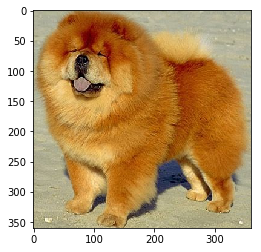

A dog is detected. Breed:


'Chow_chow'

In [35]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

import matplotlib.image as mpimg

# example 1: chow chow dog
img = mpimg.imread('image_test/chowchow.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/chowchow.jpg")

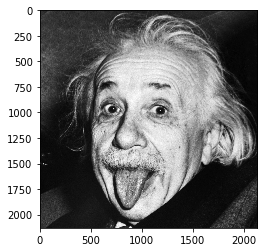

A human is detected. She/He looks like a dog with breed:


'Chinese_crested'

In [36]:
# example 2: a human
img = cv2.imread('image_test/einstein.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/einstein.jpg")

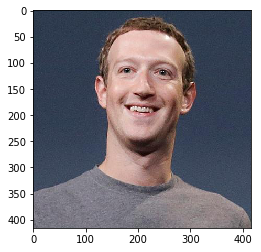

A human is detected. She/He looks like a dog with breed:


'Lowchen'

In [37]:
# example 3: a human
img = mpimg.imread('image_test/zuckerberg.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/zuckerberg.jpg")

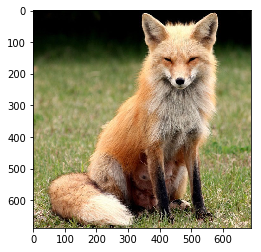

A human is detected. She/He looks like a dog with breed:


'Icelandic_sheepdog'

In [38]:
# example 4: fox
img = mpimg.imread('image_test/fox.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/fox.jpg")

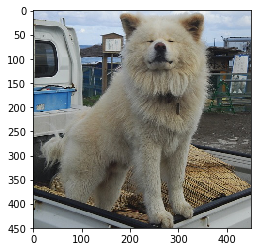

A dog is detected. Breed:


'Akita'

In [39]:
# example 5: Akita dog
img = mpimg.imread('image_test/wasao.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/wasao.jpg")

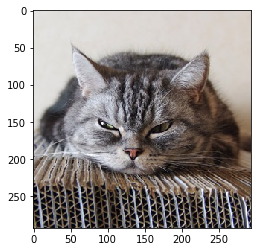

Error: This image is neither dog nor human.


In [40]:
# example 6: cat
img = mpimg.imread('image_test/gin.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/gin.jpg")

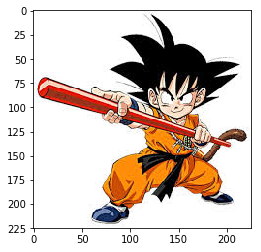

Error: This image is neither dog nor human.


In [42]:
# example 7: a human in a cartoon
img = mpimg.imread('image_test/goku.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/goku.jpg")

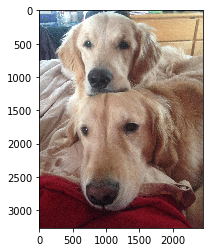

A dog is detected. Breed:


'Golden_retriever'

In [43]:
# example 8: two dogs
img = mpimg.imread('image_test/two_dogs.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/two_dogs.jpg")

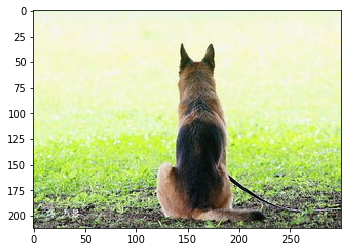

A dog is detected. Breed:


'Norwich_terrier'

In [44]:
# example 9: dog's back (German Shepherd)
img = mpimg.imread('image_test/dog_back.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/dog_back.jpg")

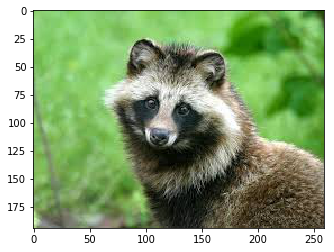

Error: This image is neither dog nor human.


In [45]:
# example 10: racoon
img = mpimg.imread('image_test/racoon.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/racoon.jpg")

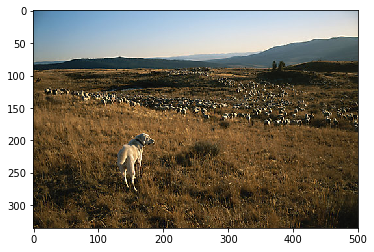

A dog is detected. Breed:


'Anatolian_shepherd_dog'

In [46]:
# example 11: dog (small in the image)
img = mpimg.imread('image_test/dog_small.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/dog_small.jpg")

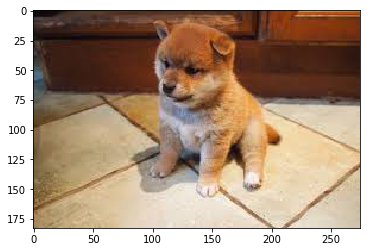

Error: This image is neither dog nor human.


In [47]:
# example 12: baby dog (shiba)
img = mpimg.imread('image_test/baby_shiba.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/baby_shiba.jpg")

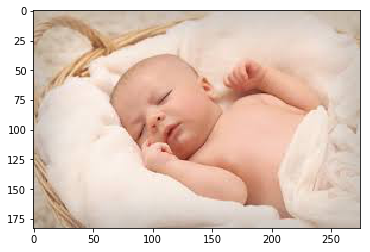

Error: This image is neither dog nor human.


In [48]:
# example 13: human baby
img = mpimg.imread('image_test/baby_human.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/baby_human.jpg")

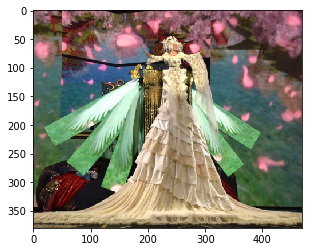

Error: This image is neither dog nor human.


In [49]:
# example 14: human (small in the image)
img = mpimg.imread('image_test/kobayashi.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human("image_test/kobayashi.jpg")

### Some points to be improved in my algorithm

The model we constructed works somehow well, but still further improvements are possible:

- When a dog's face is not shown in the image,detecting the breed seems difficult. (More images of dogs without their faces shown should be added to the training set.)

- A baby dog is hard to detect. (More images of baby dogs, or dogs in various stages more generally, should be added to the training set.)

- A human baby is hard to detect. (More images of human babies should be added to the training set.)

- When a human is small in the image, it is hard to detect. (More such images should be added to the training set or augmentation with different parameters will help.)

## Appendix A: Mixed Breed Dogs

In the above, mixed breed dogs are not taken into account. Thus any dogs in the image will be classified into 
one of the 133 breeds given in the training/test sets. For an image of a dog with a specific breed, when the probabilities for breeds are computed based on the model, the probability for a specific breed will take a very large value. Thus it is natural to introduce a threshold for the maximum value of the probabilities computed for the 133 breeds, and, when the maximum probability is higher than the threshold, we set our prediction to be the corresponding breed with the highest probability. On the other hand, when the maximum probability among the 133 breeds is lower than the threshold, we set our prediction to be the mixed breed. 

Now the question is how to set this threshold. (We note that a too high threshold will result in a high rate of misclassification for the dogs with specific breeds.) To find an appropriate value, we first look at the distribution 
of the maximum probabilities among the 133 breeds for the test set: 

In [50]:
# create a list of the maximum probabilities for each example in the dog breed classification 
max_values = [np.max(Resnet50_model_breed.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
# create a list of the results (True or False) for each example in the dog breed classification 
test_results = list(np.array(Resnet50_breed_predictions)==np.argmax(test_targets, axis=1))

# create a list of the maximum probabilities for each example classified correctly
true_results = [max_value for max_value, test_result in zip(max_values, test_results) if test_result == True] 
# create a list of the maximum probabilities for each example not classified correctly
false_results = [max_value for max_value, test_result in zip(max_values, test_results) if test_result == False] 

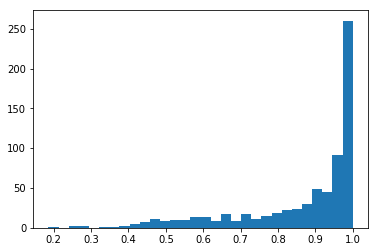

In [51]:
# create a histgram of the maximum probabilities for each example classified correctly
plt.hist(true_results, bins=30)
plt.show()

Juding from this histgram, we set the threshold to be 0.75. (We also tried other values around it, and this seems to be a reasonable choice.)

The following is the dog breed classifier with mixed breeds taken into account:

In [66]:
### dog breed detector with mixed dogs taken into account
    
# threshold for judging mixed dog
threshold_mixed = 0.75    

def Resnet50_predict_breed_mix(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model_breed.predict(bottleneck_feature)
    
    # the maximum value in the predicted vector
    max_value = np.max(predicted_vector)
    
    if(max_value > threshold_mixed):
        result_breed = dog_names[np.argmax(predicted_vector)]
    else:
        result_breed = 'mixed breed'
    
    return result_breed
    
def dog_or_dog_like_human_mix(img_path):
    if(dog_detector(img_path) == True):
        print("A dog is detected. Breed:")
        return Resnet50_predict_breed_mix(img_path)
    elif(face_detector(img_path) == True):
        print("A human is detected. She/He looks like a dog with breed:")
        return Resnet50_predict_breed_mix(img_path)
    else:
        print("Error: This image is neither dog nor human.")
        

Below, we check that how this classifier works for the images with mixed breed dogs:

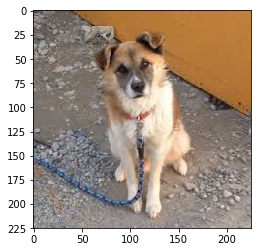

A dog is detected. Breed:


'mixed breed'

In [67]:
# example 1: mixed dog 1
img = mpimg.imread('image_test/mixed1.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human_mix("image_test/mixed1.jpg")

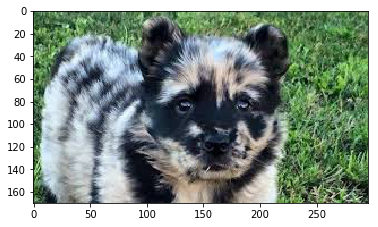

A dog is detected. Breed:


'German_shepherd_dog'

In [68]:
# example 2: mixed dog 2
img = mpimg.imread('image_test/mixed2.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human_mix("image_test/mixed2.jpg")

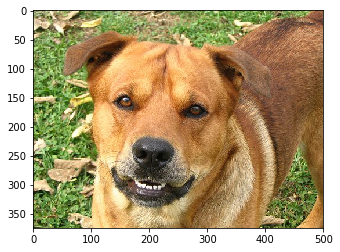

A dog is detected. Breed:


'mixed breed'

In [69]:
# example 3: mixed dog 3
img = mpimg.imread('image_test/mixed3.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human_mix("image_test/mixed3.jpg")

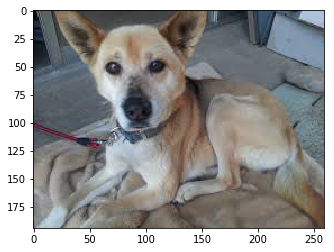

Error: This image is neither dog nor human.


In [70]:
# example 4: mixed dog 4
img = mpimg.imread('image_test/mixed4.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human_mix("image_test/mixed4.jpg")

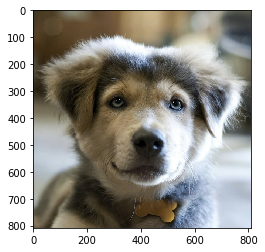

A dog is detected. Breed:


'mixed breed'

In [71]:
# example 5: mixed dog 5
img = mpimg.imread('image_test/mixed5.jpg')
plt.imshow(img)
plt.show()

dog_or_dog_like_human_mix("image_test/mixed5.jpg")

Thus, for the images with dogs detected (4 out of 5 examples), the breeds are predicted correctly as mixed for 3 out of 4 examples. 
(A higher threshold is possible but it will result in a higher rate of incorrect classification for the images with pure breed dogs. So this threshold seems to be reasonable.) Here we only took 5 images of mixed breed dogs. Check with more images will be needed. 

## Appendix B: App for dog breed classifier
Based on the model above, we created a dog breed classifier app which:

- when a dog is detected, its breed is predicted (mixed breeds are not taken into account in this app, but generalization is straightforward). 
- when a human is detected, the app predicts which dog breed she/he looks like and then return a image with dog ears and nose. 


This app is built based on the above algorithm and Flask. The app is available [here](https://github.com/datatsuo/dog_classifier_app). 
To use this app, please download the file and follow the `README.md` in it. 

Example of output: 

![Sample Dog_Trans_Output](image_test/einstein_transformed.jpg)